

# Using Runpandas to explore Nike Run Activity Data
> How to download and analyze your Nike Run activities using NRC-Export and Runpandas
- toc: false 
- badges: true
- comments: true
- author: Marcel Caraciolo
- categories: [general, jupyter, releases]
- image: images/female-runner.png

## Using the Nike Run to analyze your activities.


My wife started to run seriously since last year and used the Nike Run app to track her runs. Unfortunately, there isn't an open API to get the data and get advanced analytics on her activities. So she asked me, if there was a way to perform some analysis on her own.
At this tutorial, I will show how I fetched the data from Nike Run social app. Then, I will show how I explored that data using Python and RunPandas. Even this article is focused specifically on Nike Run activities, it will be useful for anyone interesteing in learning more about how get your running data and play with it.

### Getting your data

There are three things you will need up front.
- A Nike Run member account
- A environment to run Python. 
- To start, I will assume you have a Nike Run account with at least one activity logged.

There is a commandline program called [nrc-exporter](https://github.com/yasoob/nrc-exporter) that automates the data export to a local directory. We will use it here. The first step, is to use the terminal and install the package using pip package installer.

```
pip install nrc-exporter
```


To start using you will need the the authentication token that you can get when you login at the Nike Web account. Here are the steps:


- Login into your [Nike account](https://www.nike.com/pt/);
- Open the developer tools -> Application. Then, you need to copy the token (Authorization field) as shown at the image below:

<img src="./images/TokenNRC.png">


At your terminal, just execute the nrc-exporter with the given token as shown below:

```
nrc-exporter -t token
```

You will see the screen below after running the tool:

<img src="./images/TerminalNRC.png">

All your running data will be downloaded to a folder named activities from where you executed the script. All the activities are in JSON format.  If this step did not work for you, you can see other alternatives at the website of the owner of the tool [nrc-exporter](https://pypi.org/project/nrc-exporter/). Take a look there!

### Analyzing your activity data


In this section, I will walk you through how I used Runpandas, a library focused on running data exploratory analysis, to answer some questions that she asked me to look into:

- Have my runs gotten faster over time?
- Is my max speed higher on shorter runs?
- Do I run longer distances on the weekend than during the week?
- Do I run faster on the weekend than during the week?
- How many days do I rest compared to days I run?
- How many kilometers did I cover ?
- Which month of the year do I run the fastest?
- Which month of the year do I run the longest distance? 
- How has the average distance per run changed over the years? 
- How has the average time per run changed over the years? 
- How has my average speed per run changed over the years?
- Am I ready for a half-marathon? What would it be my finishing time ?

#### Data Import

Now, to get the data into a table, I’ll fun the following code. To read the json directory, you can run the ``runpandas.read_dir_nikerun`` method to create a Runpandas Activity Dataframe  combining the workouts as individual rows .  If you are unfamiliar with Pandas or Runpandas, consider them as Excel tables.

In [2]:
#Disable Warnings for a better visualization
import warnings
warnings.filterwarnings('ignore')

In [3]:
import runpandas as rpd
session = rpd.read_dir_nikerun('./data/nikerun_data/')

The data frame sessions holds the all the running data from the nike_run_session directory.  Let’s look at some of the data.


In [4]:
session

calories  nikefuel  steps  \
start                            time                                         
2021-05-21 09:17:20+00:00        00:00:00              NaN       NaN    NaN   
                                 00:00:07            1.719       NaN   19.0   
                                 00:00:13            0.688  3.835712   14.0   
                                 00:00:17            0.689       NaN   14.0   
                                 00:00:21            0.696  6.499274   14.0   
...                                                    ...       ...    ...   
2020-08-21 09:20:32.999000+00:00 00:50:19.001000       NaN       NaN    NaN   
                                 00:50:20.001000       NaN       NaN    NaN   
                                 00:50:21.001000       NaN       NaN    NaN   
                                 00:50:22.001000       NaN       NaN    NaN   
                                 00:50:23.001000       NaN       NaN    NaN   

                                                        alt     hr        lon  \
start                            time                                           
2021-05-21 09:17:20+00:00        00:00:00          9.371477    NaN -34.894570   
                                 00:00:07          9.369224    NaN -34.894669   
                                 00:00:13          9.451016    NaN -34.894765   
                                 00:00:17          8.976615  134.0 -34.894868   
                                 00:00:21         10.422757    NaN -34.894963   
...                                                     ...    ...        ...   
2020-08-21 09:20:32.999000+00:00 00:50:19.001000   5.323750    NaN -34.882294   
                                 00:50:20.001000   5.323750    NaN -34.882290   
                                 00:50:21.001000   5.323750    NaN -34.882283   
                                 00:50:22.001000   5.323750    NaN -34.882277   
                                 00:50:23.001000        NaN    NaN -34.882276   

                                                       lat  
start                            time                       
2021-05-21 09:17:20+00:00        00:00:00        -8.046016  
                                 00:00:07        -8.045975  
                                 00:00:13        -8.045947  
                                 00:00:17        -8.045923  
                                 00:00:21        -8.045918  
...                                                    ...  
2020-08-21 09:20:32.999000+00:00 00:50:19.001000 -8.093134  
                                 00:50:20.001000 -8.093105  
                                 00:50:21.001000 -8.093076  
                                 00:50:22.001000 -8.093048  
                                 00:50:23.001000 -8.093032  

[47711 rows x 7 columns]

By calling sessions.columns, I can see this list of features included in our dataset.  NikeRun provides interesting columns such as calories, steps, altitude, heart rate, latitude and longitude.  We are missing some valuable data such as speed, pace and the moving time.


In [5]:
session.columns

Index(['calories', 'nikefuel', 'steps', 'alt', 'hr', 'lon', 'lat'], dtype='object')

Runpandas provides special accessors that extends the capabilities of Pandas library. For sesssions we have the ``runpandas.types.acessors.session._SessionAcessor`` with several methods that computes these running metrics for all of our activities included in the DataFrame.

In [6]:
#In this session we compute the distance and the distance per position across all workouts
session = session.session.distance()
#comput the speed for each activity
session = session.session.speed(from_distances=True)
#compute the pace for each activity
session = session.session.pace()
#compute the inactivity periods for each activity
session = session.session.only_moving()

In [7]:
session

calories  nikefuel  steps  \
start                            time                                         
2021-05-21 09:17:20+00:00        00:00:00              NaN       NaN    NaN   
                                 00:00:07            1.719       NaN   19.0   
                                 00:00:13            0.688  3.835712   14.0   
                                 00:00:17            0.689       NaN   14.0   
                                 00:00:21            0.696  6.499274   14.0   
...                                                    ...       ...    ...   
2020-08-21 09:20:32.999000+00:00 00:50:19.001000       NaN       NaN    NaN   
                                 00:50:20.001000       NaN       NaN    NaN   
                                 00:50:21.001000       NaN       NaN    NaN   
                                 00:50:22.001000       NaN       NaN    NaN   
                                 00:50:23.001000       NaN       NaN    NaN   

                                                        alt     hr        lon  \
start                            time                                           
2021-05-21 09:17:20+00:00        00:00:00          9.371477    NaN -34.894570   
                                 00:00:07          9.369224    NaN -34.894669   
                                 00:00:13          9.451016    NaN -34.894765   
                                 00:00:17          8.976615  134.0 -34.894868   
                                 00:00:21         10.422757    NaN -34.894963   
...                                                     ...    ...        ...   
2020-08-21 09:20:32.999000+00:00 00:50:19.001000   5.323750    NaN -34.882294   
                                 00:50:20.001000   5.323750    NaN -34.882290   
                                 00:50:21.001000   5.323750    NaN -34.882283   
                                 00:50:22.001000   5.323750    NaN -34.882277   
                                 00:50:23.001000        NaN    NaN -34.882276   

                                                       lat    distpos  \
start                            time                                   
2021-05-21 09:17:20+00:00        00:00:00        -8.046016        NaN   
                                 00:00:07        -8.045975  11.880769   
                                 00:00:13        -8.045947  10.969975   
                                 00:00:17        -8.045923  11.716767   
                                 00:00:21        -8.045918  10.399457   
...                                                    ...        ...   
2020-08-21 09:20:32.999000+00:00 00:50:19.001000 -8.093134   3.292688   
                                 00:50:20.001000 -8.093105   3.231813   
                                 00:50:21.001000 -8.093076   3.242027   
                                 00:50:22.001000 -8.093048   3.271412   
                                 00:50:23.001000 -8.093032   1.790247   

                                                         dist     speed  \
start                            time                                     
2021-05-21 09:17:20+00:00        00:00:00                 NaN       NaN   
                                 00:00:07           11.880769  1.697253   
                                 00:00:13           22.850744  1.828329   
                                 00:00:17           34.567511  2.929192   
                                 00:00:21           44.966968  2.599864   
...                                                       ...       ...   
2020-08-21 09:20:32.999000+00:00 00:50:19.001000  7961.077354  3.292688   
                                 00:50:20.001000  7964.309167  3.231813   
                                 00:50:21.001000  7967.551194  3.242027   
                                 00:50:22.001000  7970.822606  3.271412   
                                 00:50:23.001000  7972.612852  1.790247   

                                          

Now that I have the data I want I’m ready to start doing some visualization and analysis.

#### Answering basic questions


The first question to answer is to see how many activities that my wife ran from 2020 until now (2021). The method ``runpandas.types.acessors.session._SessionAcessor.count`` answers exactly this question.




In [8]:
print('There are ', session.session.count(), ' activities available in this session.')

There are  67  activities available in this session.


But if we need to performa deeper analysis over all activities, it would be necessary a lot of conversions and aggregations to perform an overall analysis. Runpandas has a special method ``runpandas.types.acessors.session._SessionAcessor.summarize`` that summarizes all statistics  for all activities, and it drastically simplifies further processing.

In [9]:
summary = session.session.summarize()
summary

,moving_time,mean_speed,max_speed,mean_pace,max_pace,mean_moving_speed,mean_moving_pace,mean_cadence,max_cadence,mean_moving_cadence,mean_heart_rate,max_heart_rate,mean_moving_heart_rate,mean_temperature,min_temperature,max_temperature,total_distance,ellapsed_time
start,,,,,,,,,,,,,,,,,,
2020-07-03 09:50:53.162000+00:00,00:25:29.838000,2.642051,4.879655,00:06:18,00:03:24,2.665008,00:06:15,NaN,NaN,NaN,178.819923,188.0,178.872587,NaN,NaN,NaN,4089.467333,00:25:47.838000
2020-07-05 09:33:20.999000+00:00,00:05:04.999000,2.227637,6.998021,00:07:28,00:02:22,3.072098,00:05:25,NaN,NaN,NaN,168.345455,176.0,168.900000,NaN,NaN,NaN,980.162640,00:07:20.001000
2020-07-05 09:41:59.999000+00:00,00:18:19,1.918949,6.563570,00:08:41,00:02:32,2.729788,00:06:06,NaN,NaN,NaN,173.894180,185.0,174.577143,NaN,NaN,NaN,3139.401118,00:27:16
2020-07-13 09:13:58.718000+00:00,00:40:21.281000,2.509703,8.520387,00:06:38,00:01:57,2.573151,00:06:28,NaN,NaN,NaN,170.808176,185.0,170.795527,NaN,NaN,NaN,6282.491059,00:41:43.281000
2020-07-17 09:33:02.308000+00:00,00:32:07.691000,2.643278,8.365431,00:06:18,00:01:59,2.643278,00:06:18,NaN,NaN,NaN,176.436242,186.0,176.436242,NaN,NaN,NaN,5095.423045,00:32:07.691000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-20 09:16:55.163000+00:00,00:59:44.512000,2.492640,6.065895,00:06:41,00:02:44,2.749453,00:06:03,NaN,NaN,NaN,170.539809,190.0,171.231392,NaN,NaN,NaN,9965.168311,01:06:37.837000
2021-06-23 09:37:44+00:00,00:26:49.001000,2.501796,5.641343,00:06:39,00:02:57,2.568947,00:06:29,NaN,NaN,NaN,156.864865,171.0,156.957031,NaN,NaN,NaN,4165.492241,00:27:45.001000
2021-06-27 09:50:08.664000+00:00,00:31:42.336000,2.646493,32.734124,00:06:17,00:00:30,2.661853,00:06:15,NaN,NaN,NaN,166.642857,176.0,166.721116,NaN,NaN,NaN,5074.217061,00:31:57.336000


We have all the main statistics required our downstream analysis. Each row includes the the running summary . Let’s look at some of the data:

In [10]:
print(
    summary[['total_distance', 'ellapsed_time']]
      .sample(5)
      .sort_index()
      .to_string(formatters={
          'total_distance': '{:.0f}m'.format,
      }))

                                 total_distance   ellapsed_time
start                                                          
2020-08-09 09:47:14.372000+00:00          6274m 00:31:38.627000
2020-10-18 20:29:56+00:00                 6151m        00:42:22
2021-03-20 09:28:54.161000+00:00          5215m 00:38:54.840000
2021-03-28 09:31:37+00:00                 8863m        01:03:34
2021-06-11 09:30:44+00:00                 4206m 00:26:39.001000


This shows five randomly selected rows from the data frame. Let us find out over which time period these activities were recorded:



In [11]:
first_date = summary.index.min()
last_date = summary.index.max()
print('Activities recorded from %s to %s, total of %d days.' % (
    first_date.strftime('%Y-%m-%d'),
    last_date.strftime('%Y-%m-%d'),
    (last_date - first_date).days))


Activities recorded from 2020-07-03 to 2021-07-18, total of 379 days.


One year of training! We must remember that the data shows only the activities that were recorded on Nike Run.



In [12]:
summary['days_diff'] = summary.index.to_series().diff().dt.days
summary['total_distance'] = summary['total_distance'] / 1000  #conver meters to kms
summary['mean_speed'] = summary['mean_speed'] * 3.6 #convert to km/h
print('Period:', (summary.index.max() - summary.index.min()).days, 'days')
print('Total activities:', len(summary), 'activities')
print('Kms total:', summary.total_distance.sum())
print('Interval between two runs (average)):', round(summary.days_diff.mean(),2), 'days')
print('Average Pace (min/km):', summary.mean_pace.mean())
print('Average Distance (km):', round(summary.total_distance.mean(),2))

Period: 379 days
Total activities: 67 activities
Kms total: 458.36890461102126
Interval between two runs (average)): 5.27 days
Average Pace (min/km): 0 days 00:06:29.477611
Average Distance (km): 6.84


We also got some basic statistics using the pandas aggregation methods such as mean, sum, max and min. As you can see above, my wife ran 67 times with a total distance of 458kms in an interval range of 5 days between runs and a average pace of 06:29' min/km and an average distance of 6.84kms.

#### Looking more at individual activities


what were the top three activities in which she covered the longest distance?



In [13]:
print(
    (summary['total_distance'] /1000).nlargest(3)
        .to_string(float_format='%.1fkm'))

start
2021-06-13 09:22:30.985000+00:00   0.0km
2021-04-25 09:38:37.511000+00:00   0.0km
2021-02-07 09:15:40.107000+00:00   0.0km


And what were the top three activities on which she spent the most time?



In [14]:
print(
    (summary['ellapsed_time']
            .nlargest(4))
        .to_string(float_format='%.1fh'))

start
2021-06-13 09:22:30.985000+00:00   01:40:11.016000
2020-12-06 09:36:28.872000+00:00   01:26:28.128000
2021-02-07 09:15:40.107000+00:00   01:23:01.894000
2021-04-25 09:38:37.511000+00:00   01:19:04.490000


#### Answering some research questions


What is her average time and distance per day on trainnings ?

In [15]:
print(
    summary[['total_distance', 'ellapsed_time']]
        .mean()
        .to_frame('mean')
        .T)

     total_distance   ellapsed_time
mean        6.84133 00:44:25.656985


Apparently she covers about 6.8km and 44min per day on average—during activities she recorded.



#### Asking questions about months, quarters, and years


With Pandas, we can also group and aggregate data to other periods of time. For example, let’s find the day/month/quarter/year for each activity in which she covered, and see the total distance, average speed and number of trainings.  We will decompose the timestamp in Month, Week, Weekday, Year and YearMonth.

In [16]:
import pandas as pd
summary = summary.assign(Year=summary.index.year, Month=summary.index.month, Week=summary.index.week, Weekday=summary.index.weekday)
summary['Year-month'] = pd.to_datetime(summary[['Year','Month']].assign(day=1)).dt.to_period('M')
summary['Year-week'] =  summary.index.strftime('%Y-w%U')
summary

,moving_time,mean_speed,max_speed,mean_pace,max_pace,mean_moving_speed,mean_moving_pace,mean_cadence,max_cadence,mean_moving_cadence,...,max_temperature,total_distance,ellapsed_time,days_diff,Year,Month,Week,Weekday,Year-month,Year-week
start,,,,,,,,,,,,,,,,,,,,,
2020-07-03 09:50:53.162000+00:00,00:25:29.838000,9.511385,4.879655,00:06:18,00:03:24,2.665008,00:06:15,NaN,NaN,NaN,...,NaN,4.089467,00:25:47.838000,NaN,2020,7,27,4,2020-07,2020-w26
2020-07-05 09:33:20.999000+00:00,00:05:04.999000,8.019494,6.998021,00:07:28,00:02:22,3.072098,00:05:25,NaN,NaN,NaN,...,NaN,0.980163,00:07:20.001000,1.0,2020,7,27,6,2020-07,2020-w27
2020-07-05 09:41:59.999000+00:00,00:18:19,6.908218,6.563570,00:08:41,00:02:32,2.729788,00:06:06,NaN,NaN,NaN,...,NaN,3.139401,00:27:16,0.0,2020,7,27,6,2020-07,2020-w27
2020-07-13 09:13:58.718000+00:00,00:40:21.281000,9.034930,8.520387,00:06:38,00:01:57,2.573151,00:06:28,NaN,NaN,NaN,...,NaN,6.282491,00:41:43.281000,7.0,2020,7,29,0,2020-07,2020-w28
2020-07-17 09:33:02.308000+00:00,00:32:07.691000,9.515800,8.365431,00:06:18,00:01:59,2.643278,00:06:18,NaN,NaN,NaN,...,NaN,5.095423,00:32:07.691000,4.0,2020,7,29,4,2020-07,2020-w28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-20 09:16:55.163000+00:00,00:59:44.512000,8.973504,6.065895,00:06:41,00:02:44,2.749453,00:06:03,NaN,NaN,NaN,...,NaN,9.965168,01:06:37.837000,6.0,2021,6,24,6,2021-06,2021-w25
2021-06-23 09:37:44+00:00,00:26:49.001000,9.006464,5.641343,00:06:39,00:02:57,2.568947,00:06:29,NaN,NaN,NaN,...,NaN,4.165492,00:27:45.001000,3.0,2021,6,25,2,2021-06,2021-w25
2021-06-27 09:50:08.664000+00:00,00:31:42.336000,9.527376,32.734124,00:06:17,00:00:30,2.661853,00:06:15,NaN,NaN,NaN,...,NaN,5.074217,00:31:57.336000,4.0,2021,6,25,6,2021-06,2021-w26


Now we can aggregate and plot some charts using ``matplotlib`` package to see her training over the computed periods.

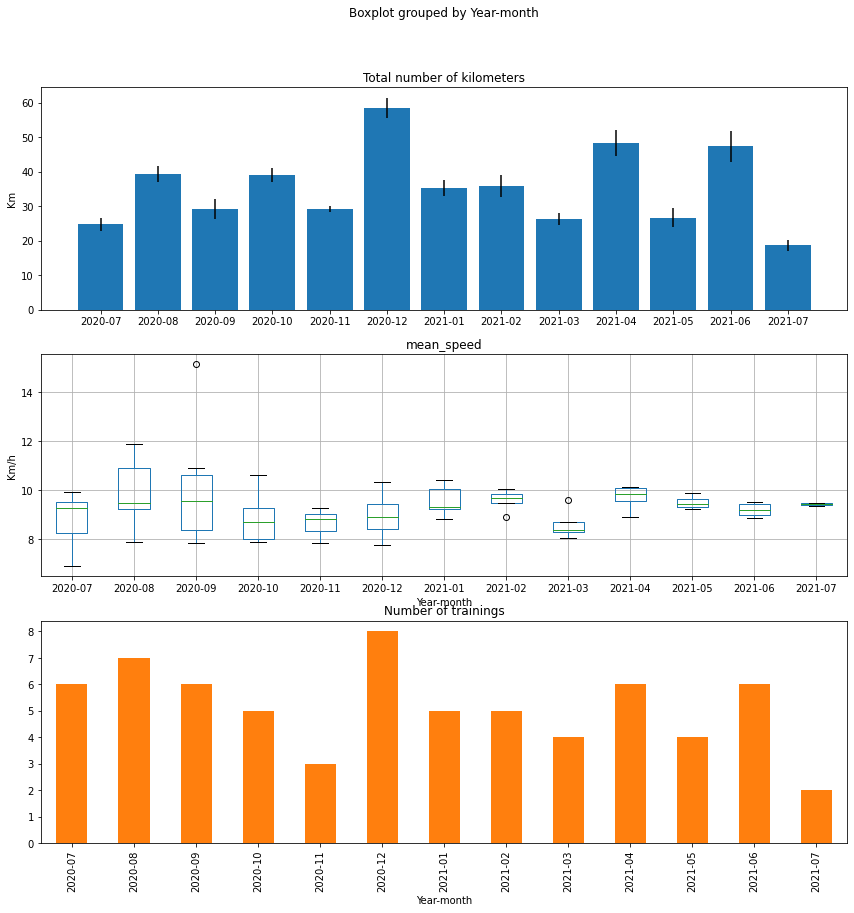

In [17]:
import matplotlib.pyplot as plt
fig, axr = plt.subplots(3,1, figsize=(14,14 ))

ticks = summary.groupby(summary['Year-month']).agg({'total_distance': 'sum'}).index.astype('str').to_list()


axr[0].bar(summary.groupby(summary['Year-month']).agg({'total_distance': 'sum'}).index.astype('str'), 
            summary.groupby(summary['Year-month']).agg({'total_distance': 'sum'}).values.flatten(),
        yerr=summary.groupby(summary['Year-month']).agg({'total_distance': 'std'}).values.flatten(),
        tick_label=ticks, label='Number of kilometers')
axr[0].set_title('Total number of kilometers')
axr[0].set_ylabel('Km')
summary.boxplot(['mean_speed'], by='Year-month', ax=axr[1])
axr[1].set_xticklabels(ticks)
axr[1].set_ylabel('Km/h')
summary.groupby('Year-month')['mean_speed'].count().plot.bar(ax=axr[2], color='C1')
axr[2].set_xticklabels(ticks)
axr[2].set_title('Number of trainings')
plt.show()


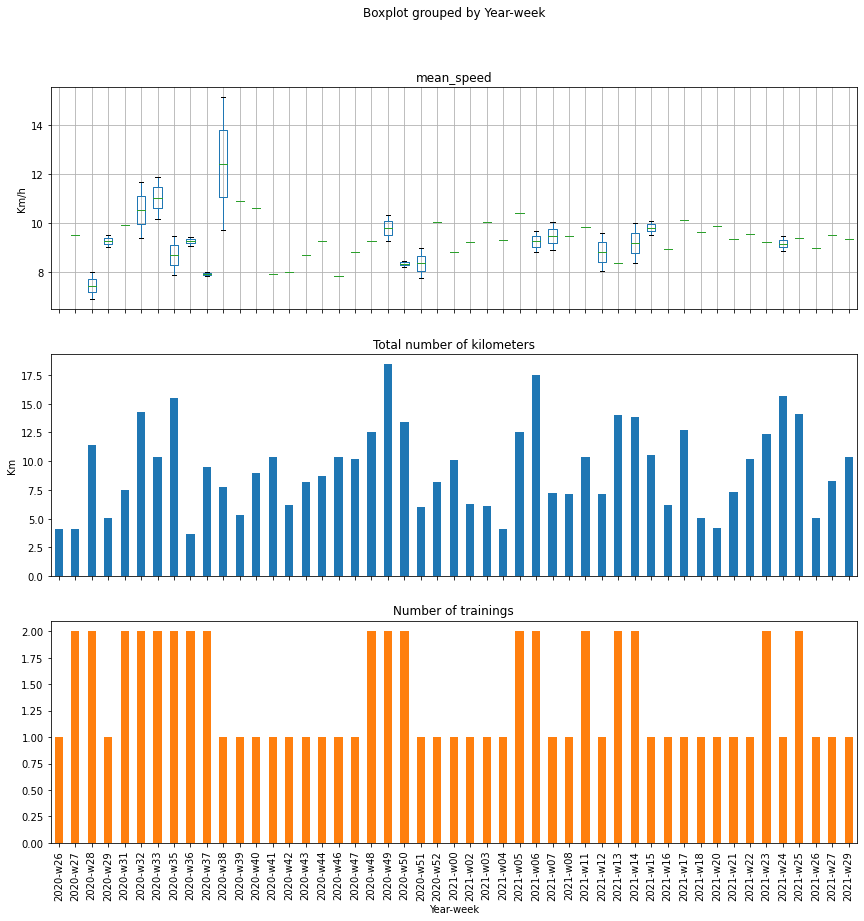

In [18]:
fig, axr = plt.subplots(3, figsize=(14,14), sharex=True)
summary.boxplot(['mean_speed'], by='Year-week', ax=axr[0])
axr[0].set_ylabel('Km/h')
summary.groupby('Year-week')['total_distance'].sum().plot.bar(ax=axr[1])
axr[1].set_title('Total number of kilometers')
axr[1].set_ylabel('Km')
summary.groupby('Year-week')['mean_speed'].count().plot.bar(ax=axr[2], color='C1')
axr[2].set_title('Number of trainings')
plt.show()

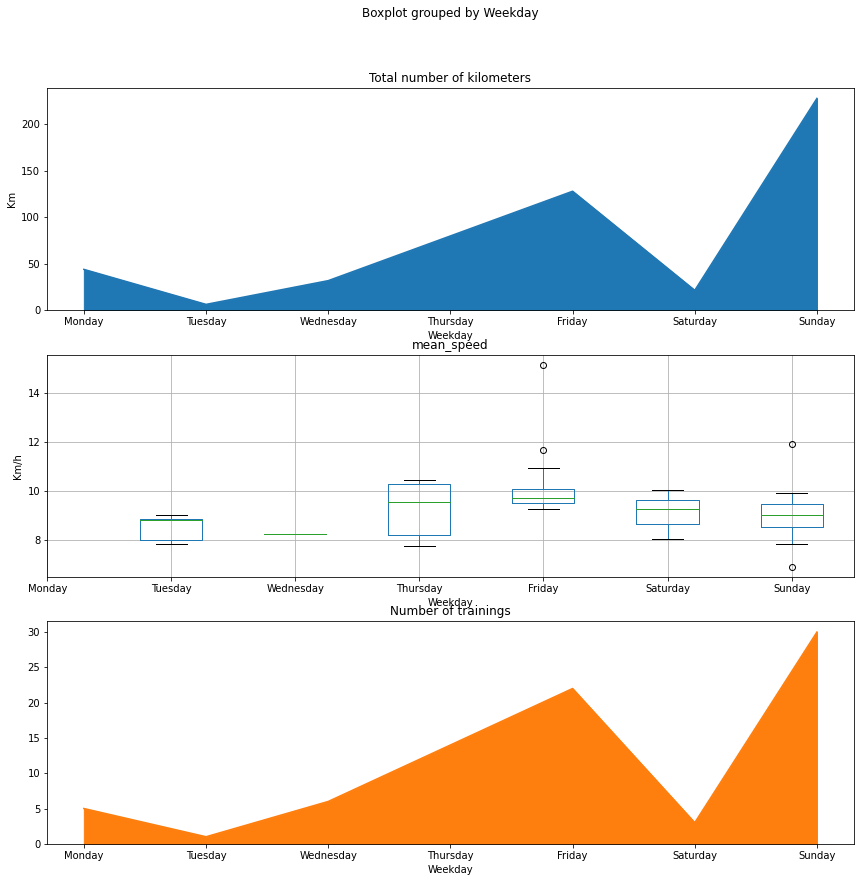

In [19]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axr = plt.subplots(3, figsize=(14,14))
summary.groupby('Weekday')['total_distance'].sum().plot.area(ax=axr[0])
axr[0].set_title('Total number of kilometers')
axr[0].set_ylabel('Km')
axr[0].set_xticks([0,1,2,3,4,5,6])
axr[0].set_xticklabels(weekdays)

summary.boxplot(['mean_speed'], by='Weekday', ax=axr[1])
axr[1].set_ylabel('Km/h')
axr[1].set_xticks([0,1,2,3,4,5,6])
axr[1].set_xticklabels(weekdays)
summary.groupby('Weekday')['mean_speed'].count().plot.area(ax=axr[2], color='C1')
axr[2].set_title('Number of trainings')
axr[2].set_xticklabels(weekdays)
axr[2].set_xticks([0,1,2,3,4,5,6])
plt.show()

Conclusions until now from the plots above:
- The month that she ran more kms was December 2020.  It corresponds to the number of the trainings also in the same month: 8 activities.
- Her Average speed didn't improve over the years, but the boxplots present from February 2021 until now a smaller variation over the mean.
- She trains one or twice a week. For a beginner the volume is ok, but not for someone training for a marathon.
- The day of the week that she runs a lot is on Sundays and then Fridays. Sunday is a rest day for her from her job, so it makes sense, more time for training!

Does she run longer distances on the weekend than during the week? Let's evaluate it by applying some pandas grouping functions. The idea is to aggregate over the weekday column.

In [20]:
import numpy as np
summary['ellapsed_time_minutes'] = summary['ellapsed_time'] / np.timedelta64(1, 'm')
summary['count'] = 1
summary_by_day = summary.groupby([pd.Grouper(freq='D', level=0)]).sum()


In [21]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
summary_by_day[['total_distance', 'ellapsed_time_minutes', 'count']].groupby(lambda d: weekdays[d.weekday()]).mean().agg(['idxmax', 'max']).T.unstack(level=0).swaplevel(1)

idxmax  total_distance             Sunday
        ellapsed_time_minutes      Sunday
        count                      Sunday
max     total_distance            4.13675
        ellapsed_time_minutes     27.2632
        count                    0.545455
dtype: object

The answer above corresponds to what we interpreted from the plots, she runs most of time and distance on Sundays! 

We can do the same for the months of the year:

In [22]:
months = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
summary_by_month = summary.groupby([pd.Grouper(freq='M', level=0)]).sum()
summary_by_month[['total_distance', 'ellapsed_time_minutes', 'count']].groupby(lambda m: months[m.month-1]).mean().agg(['idxmax', 'max']).T.unstack(level=0).swaplevel(1)


idxmax  total_distance               Dec
        ellapsed_time_minutes        Dec
        count                        Dec
max     total_distance           58.5305
        ellapsed_time_minutes     393.46
        count                          8
dtype: object

December was the month of the year in which she does most of her running on average


#### Correlations

Another question she asked was if she started running faster, on average, over the past few months?  To answer this question, I will plot the relationship between date and average pace, to see any trend.

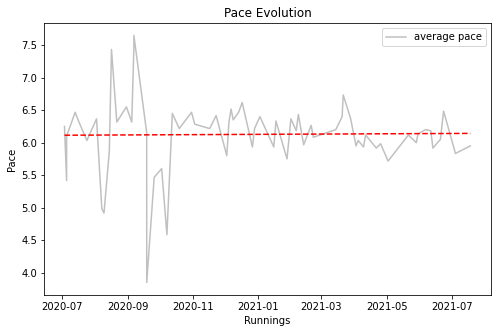

In [23]:
#let's convert the pace to float number in minutes
import datetime
summary['mean_moving_pace_float'] = summary['mean_moving_pace'] / datetime.timedelta(minutes=1)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plt.subplots(figsize=(8, 5))

plt.plot(summary.index, summary.mean_moving_pace_float, color='silver', label = 'average pace')


#add trend line
x = np.asarray(summary.index)  #convert data to numpy array
x2 = mdates.date2num(x)
y = np.asarray(summary.mean_moving_pace_float)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
#format the figure and display
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()
plt.title("Pace Evolution")
plt.xlabel("Runnings")
plt.ylabel("Pace")
plt.legend()

There isn't a indication of improvement over time, The change is a little , with a little increase over the time (trend line). But could it be the distance ,how far she runs , she slows down ? Let's see the correlation. The following code will create a regression plot of her average speed vs distance.

Text(0.5, 1.0, 'Average Speed vs Distance')

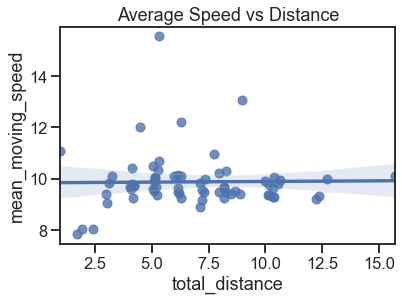

In [24]:
#Seaborn is a data visualization library.
import seaborn as sns
sns.set(style="ticks", context="talk")
sns.regplot(x='total_distance', y = summary.mean_moving_speed * 3.6, data = summary).set_title("Average Speed vs Distance")


There is not relationship as we can see from the data above, from the total distance vs moving speed, by the way, even in far distances she maintains the velocity. How about her my max speed higher on shorter runs? Is it true ? She performs on friday several shorter runs. Let's see through data:


Text(0.5, 1.0, 'Max Speed vs Distance')

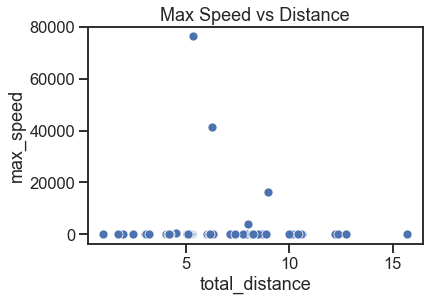

In [25]:
sns.scatterplot(x='total_distance', y =  summary.max_speed, data = summary).set_title("Max Speed vs Distance")


There are some outliers,let's remove them. Maybe due to some incorrect calculation or record registering.

Text(0.5, 1.0, 'Max Speed vs Distance')

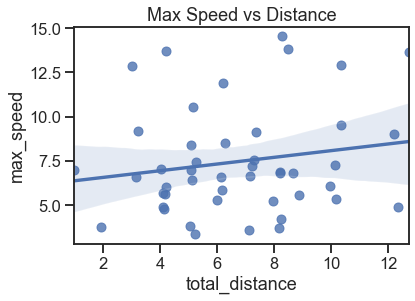

In [26]:
summary_without_outliers = summary[summary['max_speed'].between(1,15)]
sns.regplot(x='total_distance', y =  summary_without_outliers.max_speed, data = summary_without_outliers).set_title("Max Speed vs Distance")


Interesting that her speed improved as  the total distance grew, which shows that long distances don't affect her performance. She is probably a long runner!

How has the average distance, time and speed per run changed over the years? Let's see the plots over the year axis.

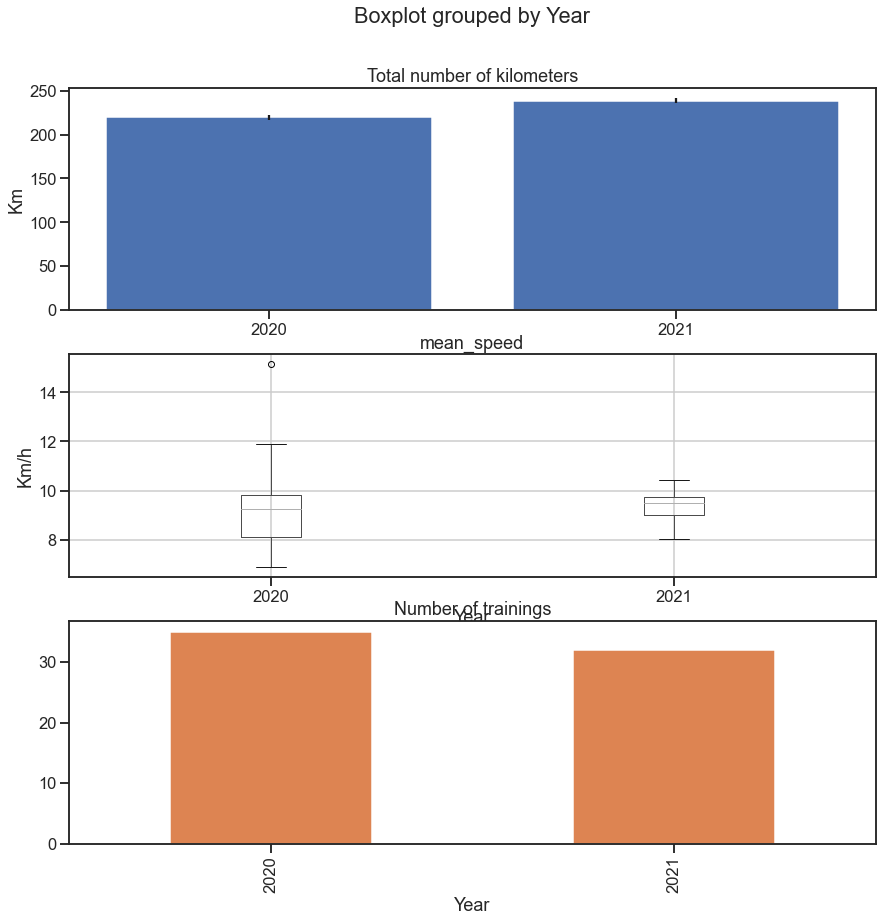

In [27]:
import matplotlib.pyplot as plt
fig, axr = plt.subplots(3,1, figsize=(14,14 ))

ticks = summary.groupby(summary['Year']).agg({'total_distance': 'sum'}).index.astype('str').to_list()


axr[0].bar(summary.groupby(summary['Year']).agg({'total_distance': 'sum'}).index.astype('str'), 
            summary.groupby(summary['Year']).agg({'total_distance': 'sum'}).values.flatten(),
        yerr=summary.groupby(summary['Year']).agg({'total_distance': 'std'}).values.flatten(),
        tick_label=ticks, label='Number of kilometers')
axr[0].set_title('Total number of kilometers')
axr[0].set_ylabel('Km')
summary.boxplot(['mean_speed'], by='Year', ax=axr[1])
axr[1].set_xticklabels(ticks)
axr[1].set_ylabel('Km/h')
summary.groupby('Year')['mean_speed'].count().plot.bar(ax=axr[2], color='C1')
axr[2].set_xticklabels(ticks)
axr[2].set_title('Number of trainings')
plt.show()


It shows that in 2021 she is running more than 2020 at almost the same period, and that her speed improved from 2020 to 2021 (the box plot show the average is greater in 2021 and less variation). She told me that she reforced the number of trainings and the exercises she has been doing to strengthen her legs.

Which month of the year do she run the fastest?


In [28]:

summary[['mean_speed', 'Year-month']].groupby('Year-month').mean().agg(['idxmax', 'max']).unstack(level=0)


mean_speed  idxmax    2020-09
            max       10.1761
dtype: object

It was on september 2020. With the average speed of 10.1761. It was one her first best 5km, we will check this later on this post.

Finally, how much time she rest vs the time she run. We can see below that there is a 5 days interval on average between the runs, which means 1 run per week. Does it affect her performance ?

In [29]:
summary['days_diff'].mean()

5.2727272727272725

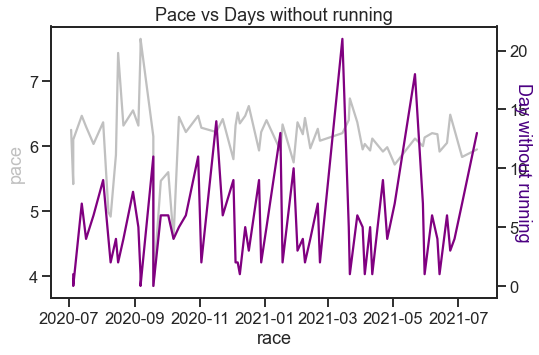

In [30]:
fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(summary.index, summary.mean_moving_pace_float, color='silver')
ax.set_xlabel('race')
ax.set_ylabel('pace',color='silver')

ax2=ax.twinx()
ax2.plot(summary.index, summary.days_diff,color='purple')
ax2.set_ylabel('Day without running',color='indigo', rotation=270)

plt.title('Pace vs Days without running')
plt.show()

Text(0.5, 1.0, 'Days Diff  vs Mean Pace')

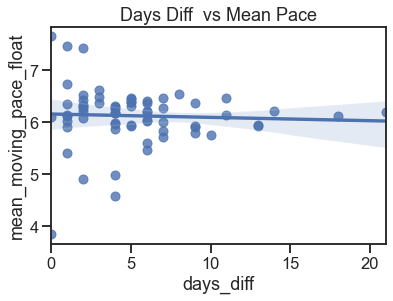

In [31]:
sns.regplot(x='days_diff', y =  summary.mean_moving_pace_float, data = summary).set_title("Days Diff  vs Mean Pace")


No relationship between the rest days vs her pace , which means the rest day doesn't affect her pace.

#### Performance over 5, 10 and 15km 

Finally, I was interested in seeing her performance evolution in pace over time in 5km, 10km and 15kms. For this analysis, I had to filter the session dataframe based on distances. In this tutorial, I will assume that the distances between 5km - 5.9km , 10km - 10.9km, 15km - 15.9km will be normalized as 5, 10 , 15km.

In [32]:
summary_5km = summary[summary['total_distance'].between(5,5.9)]
summary_5km = summary_5km[summary_5km['mean_moving_pace_float'].between(5,8)]
summary_10km = summary[summary['total_distance'].between(10,10.9)]
summary_15km = summary[summary['total_distance'].between(15,15.9)]

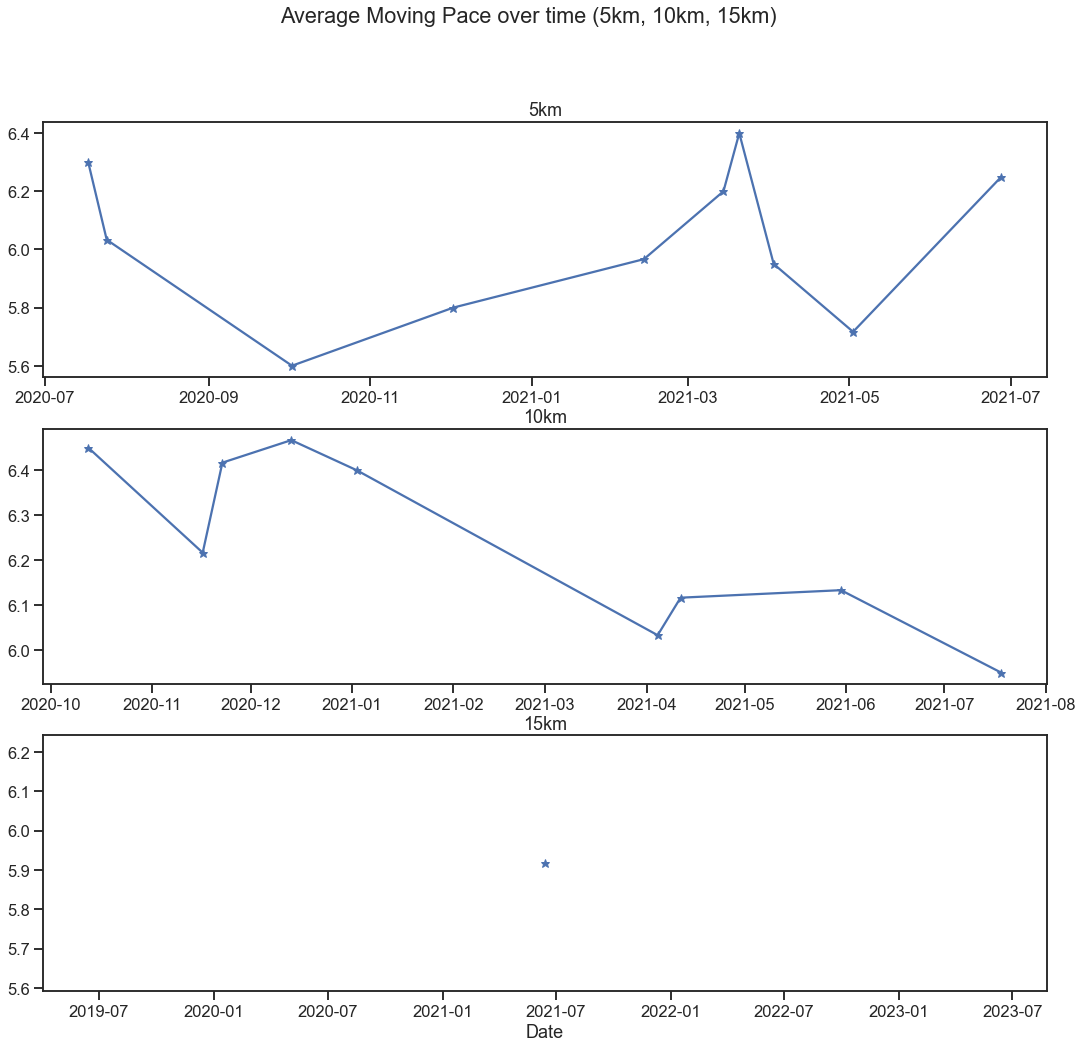

In [33]:
fig, axs = plt.subplots(3, figsize=(18, 16))
fig.suptitle('Average Moving Pace over time (5km, 10km, 15km)')

axs[0].plot(summary_5km.index, summary_5km.mean_moving_pace_float, marker='*')
axs[0].set_title('5km')
axs[1].plot(summary_10km.index, summary_10km.mean_moving_pace_float, marker='*')
axs[1].set_title('10km')


axs[2].plot(summary_15km.index, summary_15km.mean_moving_pace_float, marker='*')
axs[2].set_title('15km')

plt.xlabel('Date')
plt.show()

Her best performance on 5km was between october 2020, but her pace kept steadily along the months. In 10kms she had an amazing improvement, with the pace reducing about 40 seconds/km. The 15km she ran only one, so we don't have further information to discuss it.

#### Is she ready for a half-marathon ?

Half-Marathon is the one of the most popular races for anyone thats don't want to run the 42.195km of a full marathon and want to feel a little the taste of running half the way. Half-Marathons are quite popular and many runners even practicing for the marathon or deciding to run longer distances after the 10kms. My wife is preparing herself at the end of the year for a Half-marathon (21km) and asked me what was her predicted finishing time .

It comes to rescue machine learning techniques that can help using our historical data to predict or classify the finish  time based on the distance or some variables available. There are several models to choose in order to solve this task. I will choose one of the most classical statistics models : The linear regression. Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. In our case here, we will relate the distance, the altitude to the estimated finishing time using a linear regression model.

<img src="./images/linear-regression.png">

Illustration of a linear regression model sample.

We will use the open-source library [scikit-learn](https://scikit-learn.org/), it is the most useful and robust library for machine learning in Python. It provides a selection of efficient tools for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction via a consistence interface in Python. This library, which is largely written in Python, is built upon NumPy, SciPy and Matplotlib.



In [34]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
X_train = summary[['total_distance']].values
Y_train = summary['ellapsed_time_minutes']
X_test = np.array([21.0975]).reshape(1,-1)


In [36]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)
print('Distance: {} Km, Speed: {} Km/h, Time: {} hours \n'.format(X_test[0][0], X_test[0][0]/float(Y_pred[0]/60), Y_pred[0]/60))

Distance: 21.0975 Km, Speed: 9.019953470620834 Km/h, Time: 2.33898102342959 hours 



We arranged all the distances as inputs and all ellapsed time in minutes as outputs and used them as training set. For testing,  we want the expected finish time for the distance of 21.0975km (the half marathon official distance).  We used the method ``regr.fit``  to train the model with the historical data and we asked to predict (``regr.predict``) the finishing time.  Based on this simple model, it tell us that she will finish it in 2hrs33minutes. For a beginner it is an average finishing time, not so good, but it can get better with hard training!

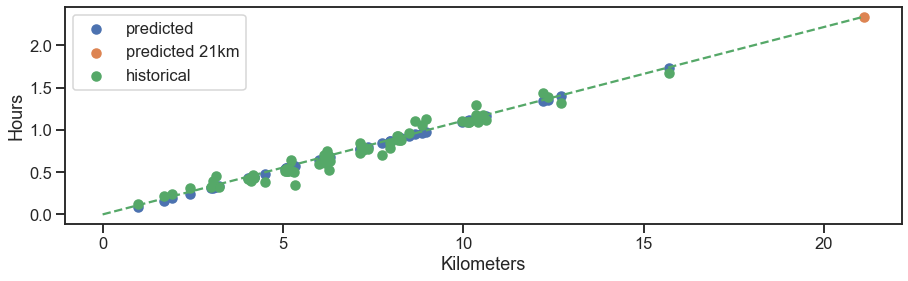

In [38]:
plt.figure(figsize=(15,4))
plt.scatter(X_train, regr.predict(X_train)/60, label='predicted')
plt.scatter(X_test, Y_pred/60, label='predicted 21km')
plt.scatter(X_train, Y_train/60, label='historical')
plt.plot([0, X_test], [0, Y_pred/60], '--', color='C2')
plt.ylabel('Hours')
plt.xlabel('Kilometers')
plt.legend(loc='upper left')
plt.show()

## Conclusions


- She is a weekeend long runner, and it still in preparation for running her half-marathon. More volume and training will help her to achieve her goals!  For long distances there some clues that she will perform with excellent times. 

There are so many ways you might explore this data. What I did above is just one example. Runpandas with other tools such as pandas, matplotlib and scikit-learn can really help you explore your running data and answer the questions that are interesting to you. Being able to captur and analyze this data open doors for any data runners that are seeking to explore their historical running activities. I hope you found this helpful and if there is anything I missed, you would like to see, or you think is incorrect, please comment below.
Additionally, here are some resources you might find helpful.

- [matplotlib](https://matplotlib.org/)
- [seaborn](https://seaborn.pydata.org/)
- [scikit-learn](https://scikit-learn.org/stable/)
- [nrc-exporter](https://github.com/yasoob/nrc-exporter)
- [linear regression](https://en.wikipedia.org/wiki/Linear_regression)